# Imports, setting up device and seeds

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torch.optim as optim

from torch.utils.data import DataLoader, random_split

In [3]:
import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

In [4]:
# torch.cuda.set_device(1)
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Constants

In [5]:
VALIDATION_PERCENTAGE = 0.10
TRAIN_PATH = "/kaggle/input/traffic/trafic_32"

# Loading data

In [6]:
%%time
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH,
                                               transform=transform)

n_val = int(np.floor(VALIDATION_PERCENTAGE * len(trainFolder)))
n_train = len(trainFolder) - n_val

train_ds, val_ds = random_split(trainFolder, [n_train, n_val])

trainloader = DataLoader(train_ds, batch_size=batch_size, drop_last=True,
                                          shuffle=True, num_workers=2)
validloader = DataLoader(val_ds , batch_size=batch_size, drop_last=True,
                                          shuffle=True, num_workers=2)

CPU times: user 1.79 s, sys: 3.41 s, total: 5.19 s
Wall time: 2min 37s


In [17]:
# takes images from valid dataset
def get_train_images(num):
    return torch.stack([val_ds[i][0] for i in range(10,10+num)], dim=0)

In [7]:
trainFolder

Dataset ImageFolder
    Number of datapoints: 39209
    Root location: /kaggle/input/traffic/trafic_32
    StandardTransform
Transform: Compose(
               ToTensor()
           )

# Model

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [10]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = eps * var + mean
        # z = np.random.normal(mean, var)
        # z = mean # Change to proper sampling
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
#         print("mean log_var", mean.shape, log_var.shape)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
#         print("z", z.shape)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [11]:
vae = VAE(latent_dim=32, hidden_dim=1024, x_dim=32*32*3).to(device)

# Training loop

In [12]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [13]:
%%time
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
#         print("X SHAPE: ", x.shape, x.shape[0])
        out, means, log_var = vae(x)
        out = out.cpu()
        x = x.cpu()
#         out = x.view (x.shape[0],3,32,32)
#         print("OUT SHAPE: ", out.shape)
#         print("X SHAPE: ", x.shape)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
        
    L1_list = []
    for x, _ in iter(validloader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
        
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 29761.20238366788, test L1 = 0.11011855800946553
Epoch 1 loss 16556.482101106296, test L1 = 0.08831675400336583
Epoch 2 loss 12743.559206774635, test L1 = 0.08174742559591928
Epoch 3 loss 10774.593600307939, test L1 = 0.07305770168701807
Epoch 4 loss 9368.293225364963, test L1 = 0.06901592413584391
Epoch 5 loss 8403.62726676551, test L1 = 0.0655860424041748
Epoch 6 loss 7738.088100906706, test L1 = 0.0630925086637338
Epoch 7 loss 7216.53390881615, test L1 = 0.061034777263800306
Epoch 8 loss 6846.538342552463, test L1 = 0.05909331788619359
Epoch 9 loss 6465.192767734945, test L1 = 0.05795571953058243
Epoch 10 loss 6118.088232778285, test L1 = 0.05683896491924922
Epoch 11 loss 5865.194271783759, test L1 = 0.05581776325901349
Epoch 12 loss 5652.007046219206, test L1 = 0.05475869799653689
Epoch 13 loss 5458.142072023266, test L1 = 0.05376675327618917
Epoch 14 loss 5359.180492985858, test L1 = 0.05307065024971962
Epoch 15 loss 5262.071085908987, test L1 = 0.05353323891758919
Ep

# Reconstructions

In [18]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


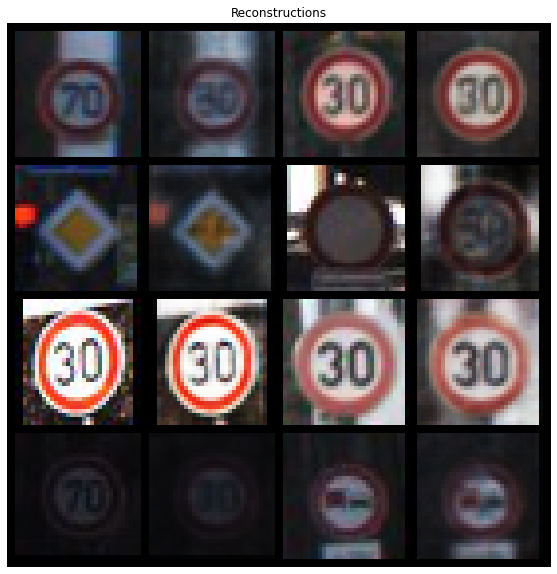

In [19]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)